### With currently how we're partitioning the belief state space, make sure there aren't any unexpected confounds
Especially interested in the high X, vs high not X case
Potential confounds to test: 
- response
- value
- chose X or not

Use either: 
- chi squared test for categorical (response, chose x or not)
- F-statistic for continous (value)

Conditions/Filters: 
- For each session/feature pair, look at high X vs. high not X
- look at when filters of response = 1, chose x or not are included

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.io_utils as io_utils
import os
from distutils.util import strtobool

import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from constants.behavioral_constants import *

from scipy import stats


In [37]:
SESSIONS_PATH = "/data/patrick_res/sessions/{sub}/valid_sessions.pickle"

def label_row(x, thresh):
    if x.PreferredBeliefProb < thresh:
        return "Low"
    elif x.FeatPreferred == "Preferred":
        return "High Pref"
    else: 
        return "High Not Pref"
    
def partition_feat_sess(all_beh, session, feat, thresh):
    beh = all_beh[all_beh.session == session].copy()
    beh["Choice"] = beh.apply(lambda x: "Chose" if x[FEATURE_TO_DIM[feat]] == feat else "Not Chose", axis=1)
    beh["FeatPreferred"] = beh["PreferredBelief"].apply(lambda x: "Preferred" if x == feat else "Not Preferred")
    beh["sess_feat"] = f"{session} {feat}"
    beh["BeliefLabel"] = beh.apply(lambda x: label_row(x, thresh), axis=1)
    return beh

def partition_by_feats(all_beh, feat_sessions, thresh):
    all_res = []
    for feat in tqdm(FEATURES):
        row = feat_sessions[feat_sessions.feat == feat].iloc[0]
        sessions = pd.Series(row.sessions)
        res = pd.concat(sessions.apply(lambda x: partition_feat_sess(all_beh, x, feat, thresh)).values)
        all_res.append(res)
    all_res = pd.concat(all_res)
    return all_res

def load_beh(sub):
    valid_sess = pd.read_pickle(SESSIONS_PATH.format(sub=sub))
    beh = pd.concat(valid_sess.apply(lambda x: behavioral_utils.get_valid_belief_beh_for_sub_sess(sub, x.session_name), axis=1).values)
    return beh

def plot_all_three(all_res):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

    choice_cont = pd.crosstab(all_res['BeliefLabel'], all_res['Choice'])
    _, p_choice, _, _ = stats.chi2_contingency(choice_cont)
    choice_probs = all_res.groupby("BeliefLabel").apply(lambda x: len(x[x.Choice == "Chose"]) / len(x)).reset_index(name="Chose Feat Prob")
    sns.barplot(choice_probs, x="BeliefLabel", y="Chose Feat Prob", ax=ax1)
    ax1.set_title(fr"$X \in a ?$, $\chi^2$ p: {p_choice}")


    reward_cont = pd.crosstab(all_res['BeliefLabel'], all_res['Response'])
    chi2, p_reward, dof, expected = stats.chi2_contingency(reward_cont)
    prob_reward = all_res.groupby("BeliefLabel").apply(lambda x: len(x[x.Response == "Correct"]) / len(x)).reset_index(name="Correct Prob")
    sns.barplot(prob_reward, x="BeliefLabel", y="Correct Prob", ax=ax2)
    ax2.set_title(fr"$R$, $\chi^2$ p: {p_reward}")

    groups = [group['BeliefStateValue'].values for name, group in all_res.groupby('BeliefLabel')]
    f_stat, p_value = stats.f_oneway(*groups)

    sns.histplot(all_res[all_res.BeliefLabel == "High Not Pref"], x="BeliefStateValue", stat="density", bins=20, alpha=0.5, label="High Not Pref", ax=ax3)
    sns.histplot(all_res[all_res.BeliefLabel == "High Pref"], x="BeliefStateValue", stat="density", bins=20, alpha=0.5, label="High Pref", ax=ax3)
    ax3.legend()
    ax3.set_title(rf"$V(b)$, F-stat p: {p_value}")

In [33]:
sub = "SA"
SESSIONS_PATH = "/data/patrick_res/sessions/{sub}/valid_sessions.pickle"
FEATS_PATH = "/data/patrick_res/sessions/{sub}/feats_at_least_3blocks.pickle"

valid_sess = pd.read_pickle(SESSIONS_PATH.format(sub=sub))
feat_sessions = pd.read_pickle(FEATS_PATH.format(sub=sub))
all_beh = load_beh(sub)

In [34]:
thresh = 0.5
all_res = partition_by_feats(all_beh, feat_sessions, thresh)
all_res = all_res[all_res.BeliefLabel.isin(["High Pref", "High Not Pref"])]

100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


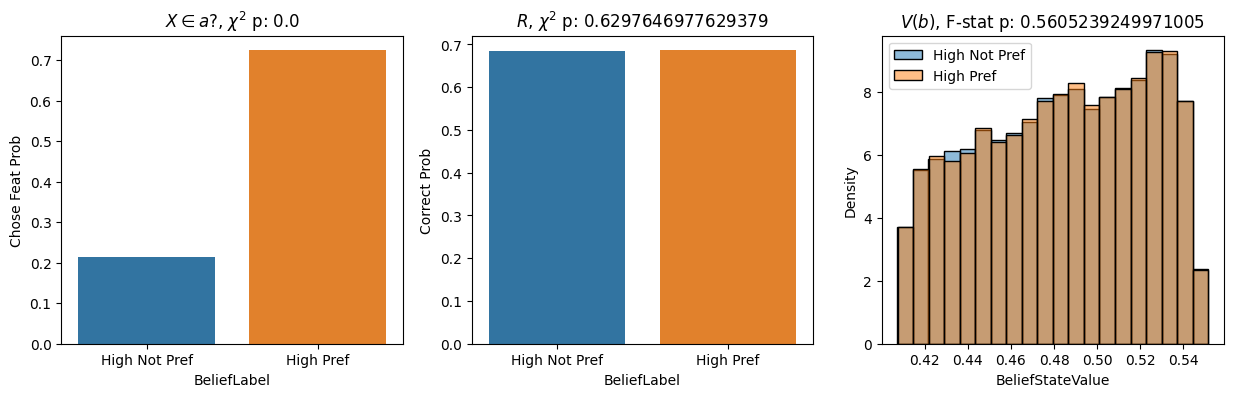

In [38]:
plot_all_three(all_res)


### See that belief state partitions for sure influence feature being on chosen card, condition on this: 

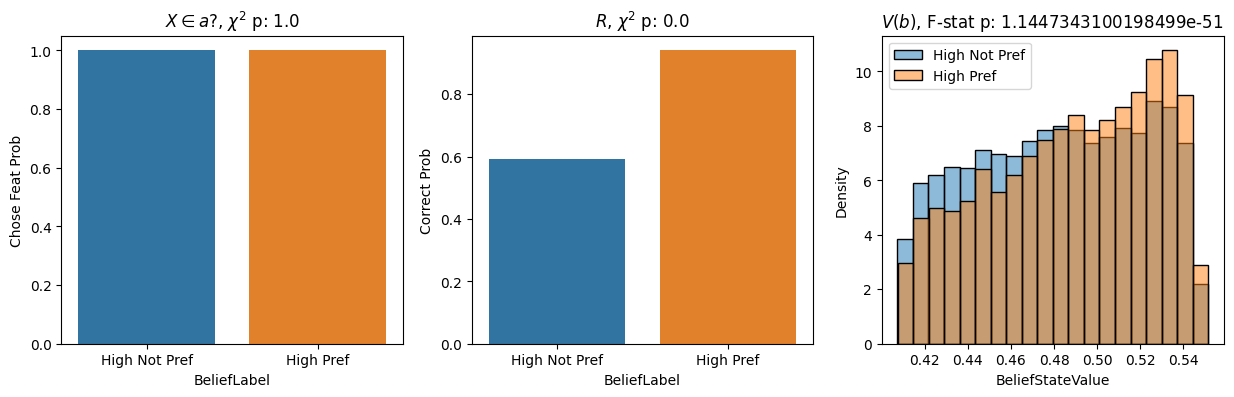

In [39]:
sub_res = all_res[all_res.Choice == "Chose"]
plot_all_three(sub_res)


### Now we've introduced a confound in reward R and value V(b), condition on reward next: 

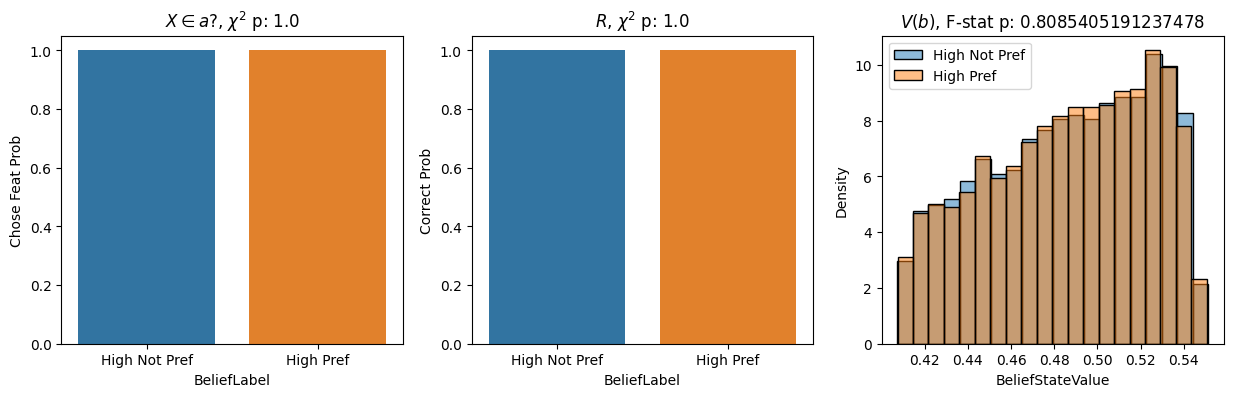

In [42]:
sub_res = all_res[(all_res.Choice == "Chose") & (all_res.Response == "Correct")]
plot_all_three(sub_res)

### This actually gets rid of Value confound as well. What if we didn't condition on reward, only on preferred card chosen?

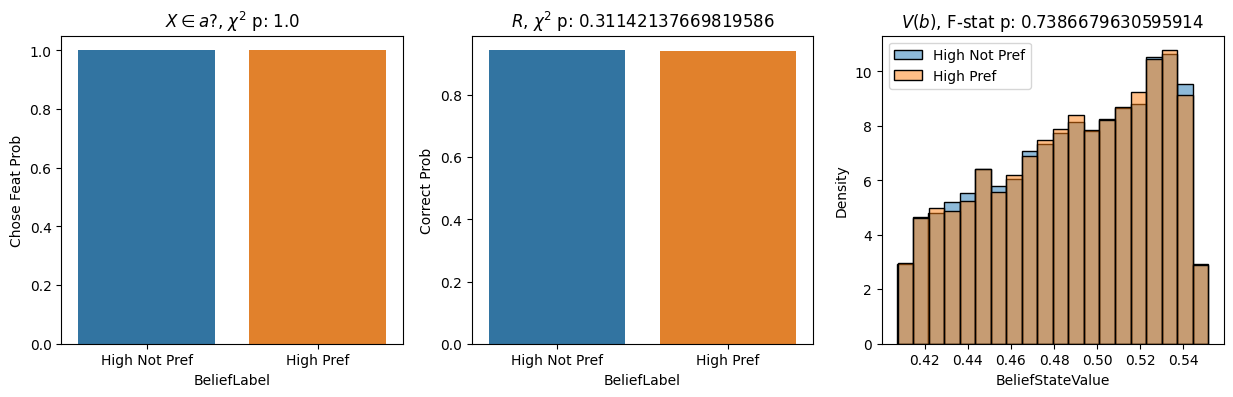

In [43]:
sub_res = all_res[(all_res.Choice == "Chose") & (all_res.PreferredChosen)]
plot_all_three(sub_res)